## Librairies :

In [2]:
from scipy.spatial import Voronoi, voronoi_plot_2d,ConvexHull
import numpy as np
import matplotlib.pyplot as plt
import DCCA 
import pandas as pd
from datetime import datetime as dt
import math

## Lecture des fichiers :

In [3]:

"""
Préparation du dataset   
fichier = open("BS_Locations/Lille_antenna_location.csv",'r')
fichier2 = open("BS_Locations/Lille_antenna_location2.csv",'w')        # On rajoute un tilde à la fin pour éviter d'écraser le fichier source en cas de bug
lignes = fichier.readlines()                # On parcours les lignes du fichier source
for ligne in lignes:
    ligneFinale = ligne.replace(';',', ')            # On remplace tout les espaces par groupe de 4 en tabulation
    fichier2.write(ligneFinale)             # On écrit la nouvelle ligne dans le nouveau fichier
                 
fichier.close()                     # Fermeture du fichier source
fichier2.close()    
"""       
df_geo=pd.read_csv("BS_Locations/Lille_antenna_location2.csv")

df_geo_norm=DCCA.normalize_distance(df_geo) #a que les deux colonnes X et Y sans ID

#Avec les heures 
"""
fichier = open("data/Lille/Lille.csv",'r')
fichier2 = open("data/Lille/Lille_traite.csv",'w')        # On rajoute un tilde à la fin pour éviter d'écraser le fichier source en cas de bug
lignes = fichier.readlines()                # On parcours les lignes du fichier source
for ligne in lignes:
    ligneFinale = ligne.replace(';',', ')            # On remplace tout les espaces par groupe de 4 en tabulation
    fichier2.write(ligneFinale) 
fichier.close()                     # Fermeture du fichier source
fichier2.close()
"""
df_traffic=pd.read_csv("data/Lille/Lille_traite.csv")



## Le trafic par jour :

In [4]:
traffic_per_day={}
for t in range(len(df_traffic)):
    day=(df_traffic[' TimeSlot'][t])[1:11]
    if (not day in traffic_per_day.keys()):
        traffic_per_day[day]=df_traffic.loc[df_traffic[' TimeSlot'].str.contains(day)]

In [5]:
for d in traffic_per_day.keys():
    print(d,np.size(traffic_per_day[d]['CellID'].unique()))

2019-03-19 760
2019-03-20 762
2019-03-21 760
2019-03-22 764
2019-03-25 763
2019-03-26 768
2019-03-27 771
2019-03-28 772
2019-03-29 776
2019-03-30 775
2019-04-01 774
2019-04-03 773
2019-04-04 776
2019-04-05 775
2019-04-22 766
2019-04-23 767
2019-04-24 767
2019-04-25 769
2019-04-26 775
2019-04-29 767
2019-04-30 768
2019-03-16 757
2019-03-17 753
2019-05-01 754
2019-05-02 763
2019-05-03 767
2019-05-04 764
2019-05-05 760
2019-05-06 765
2019-05-07 775
2019-05-08 774
2019-05-09 779
2019-05-11 766
2019-05-12 771
2019-05-13 778
2019-05-16 779
2019-05-17 779
2019-05-18 764
2019-05-26 774
2019-05-27 778
2019-05-29 779
2019-06-03 776
2019-06-04 774
2019-06-05 772
2019-06-06 774
2019-06-07 772
2019-06-12 773
2019-06-13 774
2019-06-14 777
2019-06-15 775
2019-03-18 760
2019-03-24 760
2019-04-07 772
2019-04-13 772
2019-04-14 772
2019-04-20 771
2019-04-21 764
2019-04-28 361
2019-04-15 776
2019-04-16 776
2019-04-17 776
2019-04-18 776
2019-04-19 776
2019-03-31 772
2019-04-02 772
2019-04-06 775
2019-05-19

## Déclaration des variables globales :

In [6]:
dt=1  #DeltaT = 1heure
Nt=int(24/dt)  #nombre de timespan  par jour
NBBU=2
CBBU=1
To=0.04
max_iter=20
iter_converge=6

## Génération de la matrice F de trafic pour 24h:

In [7]:
def generate_day_matrix(day):
    #Nr=df_geo_norm.count()[0]  #nombre des RRHs
    train_traffic=traffic_per_day[day]
    RRH_ID=train_traffic['CellID'].unique()
    Nr=np.size(RRH_ID)  # nbre de RRH dans données trafic < nbre RRHs dans geo données
    r=[]
    F=np.empty([Nr,Nt])
    Fup=np.empty([Nr,Nt])
    for i in range (Nr) :
        id=RRH_ID[i]
        trafic_RRH =train_traffic.loc[train_traffic['CellID']==id,:]
        for h in range(Nt):
            #print(     "H= ",h,"/24")
            if (h <10):
                sh='0'+str(h)
            else:
                sh=str(h)
            tu=0
            td=0
            nbr=0
            j=0
            for ind in (trafic_RRH.index.values):
                slot=trafic_RRH.iloc[j]
                if(slot[' TimeSlot'][12:14] == sh):
                    trafic_RRH=trafic_RRH.drop([ind])
                    nbr+=1
                    td+=slot[' ByteDn']
                    tu+=slot[' ByteUp'] 
                else:
                    j+=1
            if(nbr >0):
                F[i][h]=td/nbr
                Fup[i][h]=tu/nbr 
            else :
                F[i][h]=td
                Fup[i][h]=tu
        r.append(DCCA.RRH(id,i,df_geo_norm.iloc[i,0],df_geo_norm.iloc[i,1],F[i]))
    return F,Fup,r

In [100]:
#F,Fup,r=generate_day_matrix("2019-03-19")

## Application de DCCA :

In [8]:
def apply_DCCA(F_norm,r,To,CBBU):
    T=DCCA.peak_tracking(CBBU,F_norm,r)  
    W=DCCA.matriceComplementarite(r,CBBU,To)
    P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
    return P,l

In [49]:
"""
print(df_geo.head(4))
print(df_geo_norm.iloc[3,0])
print(df_geo.iloc[3,0])
print(df_geo.loc[df_geo['LocInfo']=="0102f81000655dd0",:])
(df_geo.loc[df_geo['LocInfo']=="0102f81000655dd0",:]).iloc[0,1]
"""

'\nprint(df_geo.head(4))\nprint(df_geo_norm.iloc[3,0])\nprint(df_geo.iloc[3,0])\nprint(df_geo.loc[df_geo[\'LocInfo\']=="0102f81000655dd0",:])\n(df_geo.loc[df_geo[\'LocInfo\']=="0102f81000655dd0",:]).iloc[0,1]\n'

In [50]:
"""
lescomp=np.array(lescomp)
print("K =",k,"\n",
      "max :",np.max(lescomp),"\n",
      "min :",np.min(lescomp),"\n",
      "moyenne :",np.mean(lescomp),"\n",
      "mediane :",np.median(lescomp),)
#plt.hist(lescomp,bins='auto')
"""

'\nlescomp=np.array(lescomp)\nprint("K =",k,"\n",\n      "max :",np.max(lescomp),"\n",\n      "min :",np.min(lescomp),"\n",\n      "moyenne :",np.mean(lescomp),"\n",\n      "mediane :",np.median(lescomp),)\n#plt.hist(lescomp,bins=\'auto\')\n'

## Affichage simple des clusters :

In [9]:
""" affichage des clusters """
def display_cluster(P):
    k=0
    lescomp=[]
    plt.title("Clustering DCCA, To =0.24")
    coord_X=[]
    coord_Y=[]
    coord=[]
    clusters=[]
    for C in P:
        if (C!=[]):
            k+=1
            lescomp.append(DCCA.complementarity(C,CBBU))
            X=np.empty([len(C),2])
            for i in range(len(C)):
                ligne=df_geo.loc[df_geo['LocInfo']==C[i].id,:]
                x=ligne.iloc[0,1]
                y=ligne.iloc[0,2]
                X[i][0]=x
                X[i][1]=y
                coord_X.append(x)
                coord_Y.append(y)
                if(not [x,y] in coord):
                    coord.append([x,y])
                clusters.append(k)
            plt.scatter(X[:,0],X[:,1])
    return coord,clusters,k

## Affichage des clusters avec voronoi :

In [10]:
from scipy.spatial import Voronoi, voronoi_plot_2d,ConvexHull
from matplotlib import cm
import matplotlib as mpl
import random
import colorsys
def colors1(n):
    ret = []
    r = int(random.random() * 256)
    g = int(random.random() * 256)
    b = int(random.random() * 256)
    step = 256 / n
    for i in range(n):
        r += step
        g += step
        b += step
        r = int(r) % 256
        g = int(g) % 256
        b = int(b) % 256
        ret.append((r/256,g/265,b/256)) 
    return ret
def colors(N):
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(N)]
    return color



def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))
        
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def affichage_vor(P,coord,col,title): 
    vor = Voronoi(coord)
    fig=voronoi_plot_2d(vor, show_points=True, show_vertices=False, s=1,line_colors='white',line_width=0.5, line_alpha=0.3)
    regions, vertices = voronoi_finite_polygons_2d(vor)
    r=0
    for region in regions:
        polygon = vertices[region]
        plt.fill(*zip(*polygon), color=col[clusters[r]]) 
        r+=1
    fig.suptitle(title)
    plt.show()

   

## Tests :

### DCCA avec 24 timespan 

In [11]:
F,Fup,r=generate_day_matrix("2019-05-23")
F_norm=DCCA.normalize_trafic(F)
for i in range(len(r)):
        r[i].setTrafic(F_norm[i])

In [40]:
color=colors(150)

231


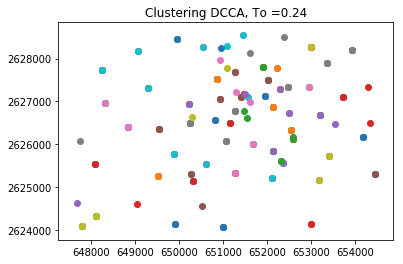

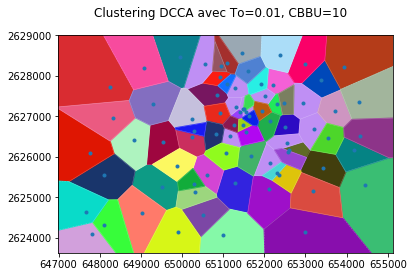

In [43]:
CBBU=10
To=0.01
P,l=apply_DCCA(F_norm,r,To,CBBU)
coord,clusters,k=display_cluster(P)
print(k)
color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.01, CBBU=10")

#### Valeur de To:

116


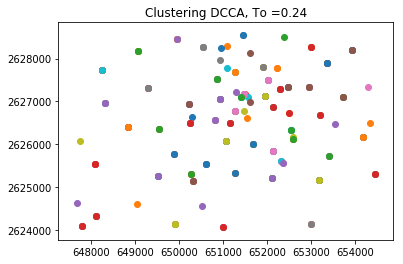

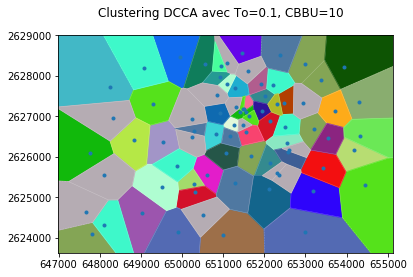

In [44]:
NBBU=2
CBBU=10
To=0.1
#P,l=apply_DCCA(F,r,To,CBBU)

T=DCCA.peak_tracking(CBBU,F_norm,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.1, CBBU=10")

49


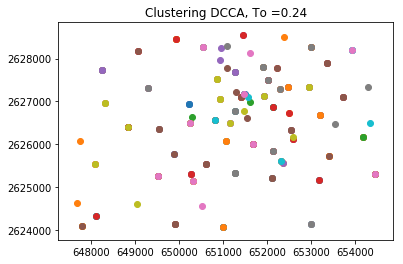

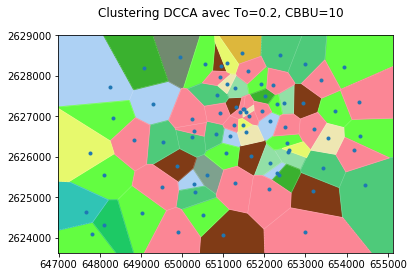

In [45]:
NBBU=2
CBBU=10
To=0.2
#P,l=apply_DCCA(F,r,To,CBBU)

T=DCCA.peak_tracking(CBBU,F_norm,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.2, CBBU=10")

36


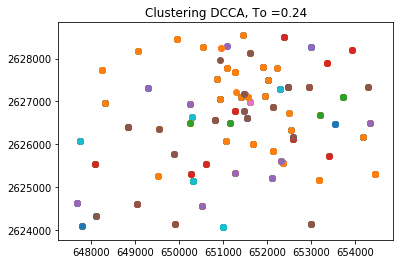

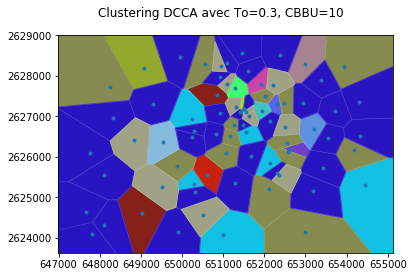

In [61]:
NBBU=2
CBBU=10
To=0.3
#P,l=apply_DCCA(F,r,To,CBBU)

T=DCCA.peak_tracking(CBBU,F_norm,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.3, CBBU=10")

21


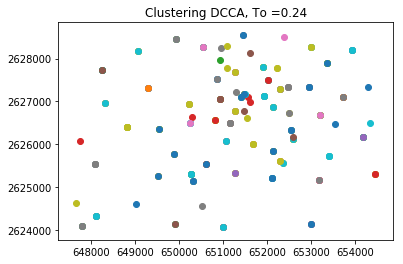

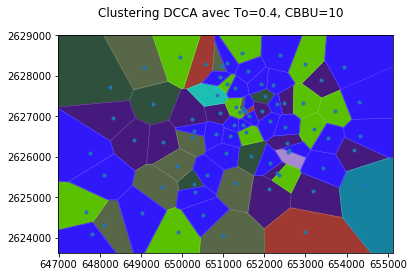

In [47]:
NBBU=2
CBBU=10
To=0.4
#P,l=apply_DCCA(F,r,To,CBBU)

T=DCCA.peak_tracking(CBBU,F_norm,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.4, CBBU=10")

19


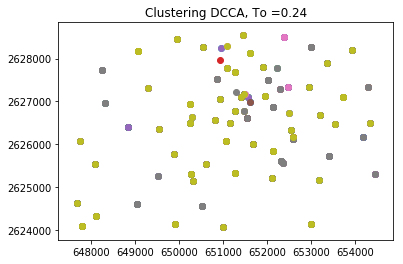

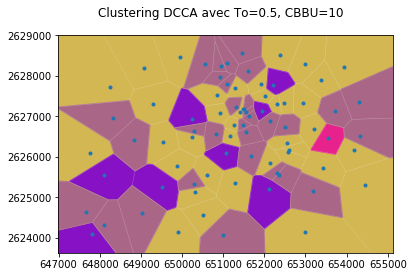

In [71]:
NBBU=2
CBBU=10
To=0.5
#P,l=apply_DCCA(F,r,To,CBBU)

T=DCCA.peak_tracking(CBBU,F_norm,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.5, CBBU=10")

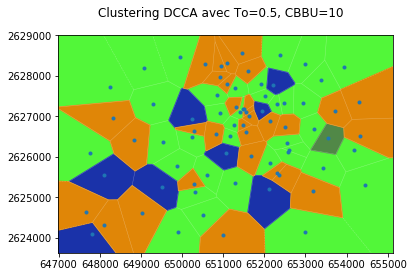

In [74]:
color=colors(18)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.5, CBBU=10")

13


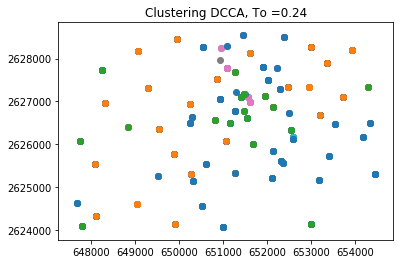

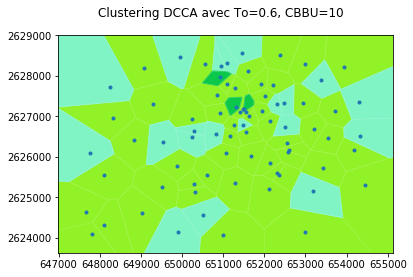

In [65]:
NBBU=2
CBBU=10
To=0.6
#P,l=apply_DCCA(F,r,To,CBBU)

T=DCCA.peak_tracking(CBBU,F_norm,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.6, CBBU=10")

9


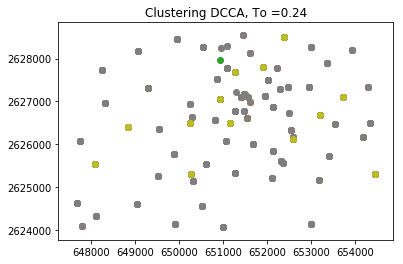

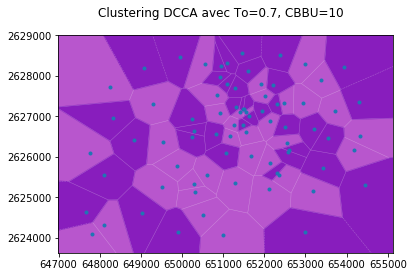

In [66]:
NBBU=2
CBBU=10
To=0.7
#P,l=apply_DCCA(F,r,To,CBBU)

T=DCCA.peak_tracking(CBBU,F_norm,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.7, CBBU=10")

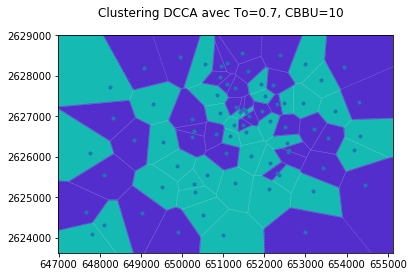

In [68]:
color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.7, CBBU=10")

8


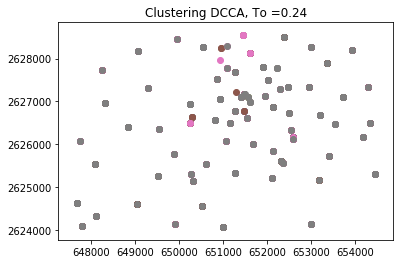

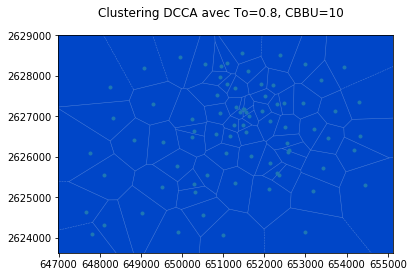

In [76]:
NBBU=2
CBBU=10
To=0.8
#P,l=apply_DCCA(F,r,To,CBBU)

T=DCCA.peak_tracking(CBBU,F_norm,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.8, CBBU=10")

6


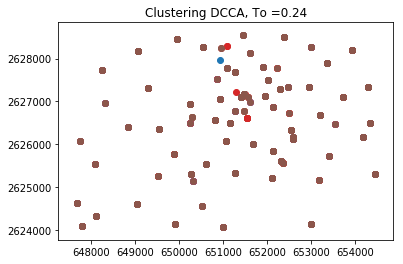

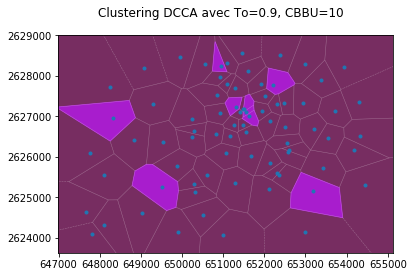

In [77]:
NBBU=2
CBBU=10
To=0.9
#P,l=apply_DCCA(F,r,To,CBBU)

T=DCCA.peak_tracking(CBBU,F_norm,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.9, CBBU=10")

14


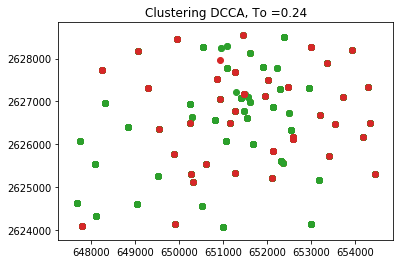

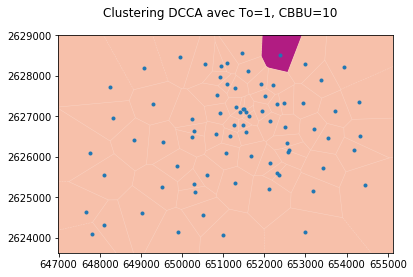

In [78]:
NBBU=2
CBBU=10
To=1
#P,l=apply_DCCA(F,r,To,CBBU)

T=DCCA.peak_tracking(CBBU,F_norm,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=1, CBBU=10")

27


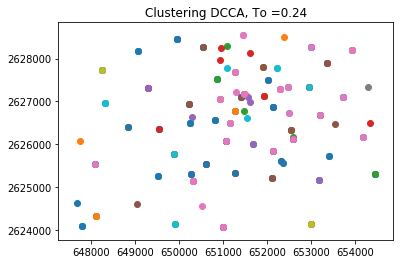

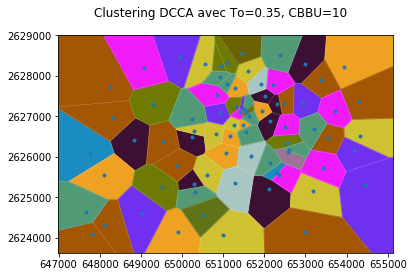

In [54]:
NBBU=2
CBBU=10
To=0.35
#P,l=apply_DCCA(F,r,To,CBBU)

T=DCCA.peak_tracking(CBBU,F_norm,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.35, CBBU=10")

#### Valeurs de Capacité de la BBU :

13
[45  0 43 27 33 34 68 73 42 70 60 25 48 36 39 37 67 41 51 58 21 76  9  2
 50  1 19 62 17 55 28 56 30 69 49 14 74 72 57 44 75 52 47 71 12 63 13 66
 26 29  4 11 46 35 59 15  6  5 77 40 54 22 23 18 61  7 16 65 64  8 53 31
 78  3 32 38 20 24]


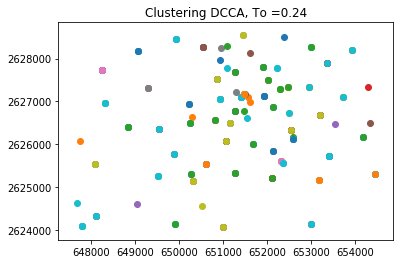

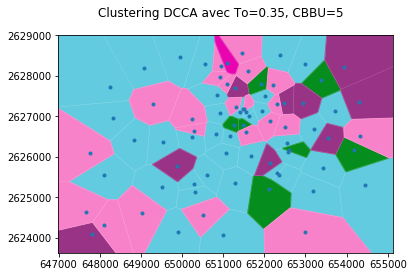

In [119]:
NBBU=2
CBBU=5
To=0.35
#P,l=apply_DCCA(F,r,To,CBBU)

T=DCCA.peak_tracking(CBBU,F_norm,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.35, CBBU=5")

13
[29 35 14  7 18 60  6 15 34 16 59 56 61 32 66 63  0 33 43 30 73 70 51 48
 62 41 37 25  9 42 12 76 39 68 21 58  1  2 28 55 50 36 69 11 19 67 45 17
 27 49 52 54 22 23 77 20 72 74 38 71 65 53  4 40 47 78 31 26  3  8 57 64
 46  5 44 75 13 24]


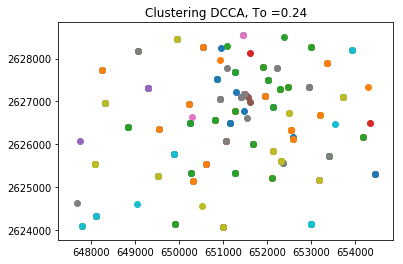

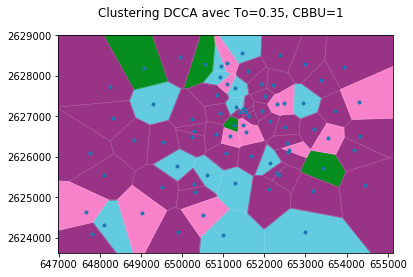

In [120]:
NBBU=2
CBBU=1
To=0.35
#P,l=apply_DCCA(F,r,To,CBBU)

T=DCCA.peak_tracking(CBBU,F_norm,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.35, CBBU=1")

15
[20 34 51  7  6 35 56 16 61 60 18 15 59 29 14 33 73 39 43 41 76 21 58 28
  9 68 19 62 37 67 25 50 30  0 48  2 45  1 36 55 42 17 70 27 69 49 63 52
 12 71 66 47 38 74 13 72  8 64 65 26 11  4 40 57 75 44 77 31 53 78  3 22
 23 54 24  5 46 32]


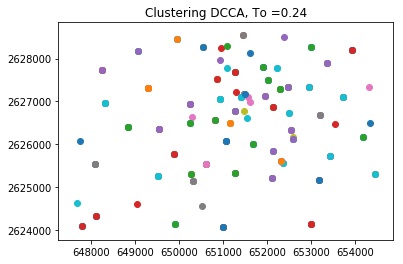

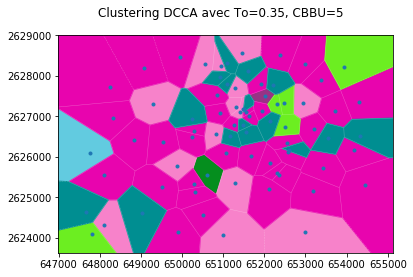

In [121]:
NBBU=2
CBBU=5
To=0.35
#P,l=apply_DCCA(F,r,To,CBBU)

T=DCCA.peak_tracking(CBBU,F_norm,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.35, CBBU=5")

13
[13 12 63 42 52 67 71 33 40  2 68 34 76 26 37 47 28 11 62 15 19 69 58 50
 75 44 41 57 72 49 39 14 74 70 66 38 60 45 25 21  8  7 64 65 30  1 29 73
  4 16 18 35 61  0 56  6 59 46 32 36 55  9 22 48 43 51 23 27 77 53 78 17
 31  3 24  5 20 54]


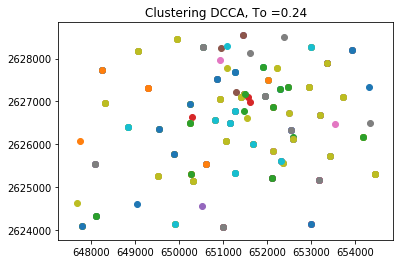

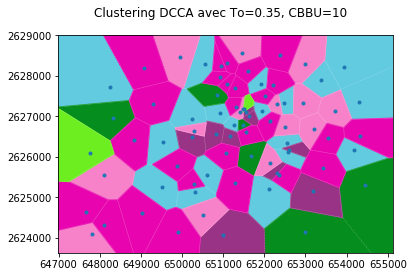

In [122]:
NBBU=2
CBBU=10
To=0.35
#P,l=apply_DCCA(F,r,To,CBBU)

T=DCCA.peak_tracking(CBBU,F_norm,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.35, CBBU=10")

13
[14 21 25 68 11 19  8 30 66  7 67 57 65 58 64 28 70  4 49 45 26 62  1 40
 15 35 59  2 77 41 50 44 76 75 33 43 48 42 39 73 17 60  9 37  0 55 34 69
 36 51 56 27 12 52 47 71 13 63 29 72 74 16  6 18 61 32 46  5 54 22 23 24
 38 20 53 78 31  3]


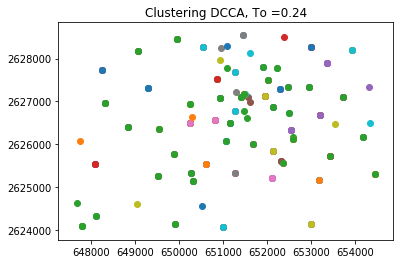

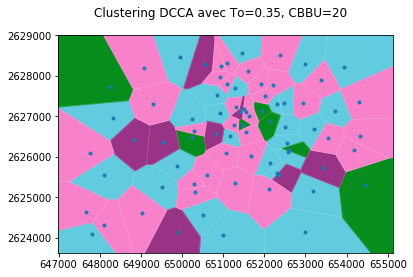

In [123]:
NBBU=2
CBBU=20
To=0.35
#P,l=apply_DCCA(F,r,To,CBBU)

T=DCCA.peak_tracking(CBBU,F_norm,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.35, CBBU=20")

In [124]:
def evaluate_CBBU (P,CBBU):
    ecart=[]
    for C in P:
        if (C!=[]):
            traf_arg=DCCA.aggregationTrafic(C)
            ecart.append(CBBU-max(traf_arg))
    return ecart

lesmax=[]
lesmin=[]
for i in range(1,10):
    CBBU=i
    T=DCCA.peak_tracking(CBBU,F_norm,r)  
    W=DCCA.matriceComplementarite(r,CBBU,To)
    P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
    e=evaluate_CBBU(P,CBBU)
    lesmax.append(max(e))
    lesmin.append(min(e))

[-2.458917187930816, -1.4255107928298827, -0.7757139555209691, -1.0482328665796414, 1.0597206826102705, 1.334557803656974, 3.0597206826102705, 4.6101543389310375, 5.6101543389310375]


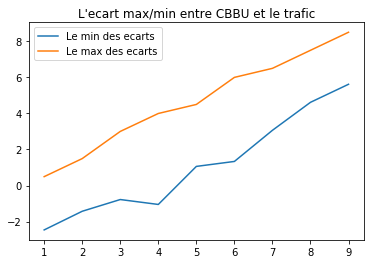

In [125]:
print(lesmin)
x=list(np.arange(1,10))
plt.title("L'ecart max/min entre CBBU et le trafic")
plt.plot(x, lesmin, label="Le min des ecarts ")
plt.plot(x, lesmax, label="Le max des ecarts")
plt.legend()
plt.show()

## Clustering Par Tranche :

## Jour de semaine:

In [98]:
F,Fup,r=generate_day_matrix("2019-03-20")
F_norm=DCCA.normalize_trafic(F)
for i in range(len(r)):
        r[i].setTrafic(F_norm[i])

### 1. Création de Timespans

In [99]:
F1=F_norm[:,0:8]
F2=F_norm[:,8:12]
F3=F_norm[:,12:16]
F4=F_norm[:,16:23]
print(np.shape(F1))

(762, 8)


### 2. Choix de CBBU

In [57]:
lesmax=[]
lesmin=[]
for i in range(1,11):
    CBBU=i
    T=DCCA.peak_tracking(CBBU,F_norm,r)  
    W=DCCA.matriceComplementarite(r,CBBU,To)
    P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
    e=evaluate_CBBU(P,CBBU)
    lesmax.append(max(e))
    lesmin.append(min(e))


NameError: name 'evaluate_CBBU' is not defined

In [ ]:
print(lesmin)
x=list(np.arange(1,11))
plt.title("L'ecart max/min entre CBBU et le trafic")
plt.plot(x, lesmin, label="Le min des ecarts ")
plt.plot(x, lesmax, label="Le max des ecarts")
plt.legend()
plt.show()

Le min des écarts n'evoule pas en monotonie car on exécute DCCA à chaque fois qui génère des clusters différents à chaque exécution et donc le trafic aggregé diffère.

### 3. Choix de To

In [ ]:
CBBU=8
To=0.35
#P,l=apply_DCCA(F,r,To,CBBU)

T=DCCA.peak_tracking(CBBU,F_norm,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
color=colors(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.35, CBBU=10")

In [ ]:
To=0.25
#P,l=apply_DCCA(F,r,To,CBBU)

T=DCCA.peak_tracking(CBBU,F_norm,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F_norm,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
affichage_vor(clusters,coord,color, "Clustering DCCA avec To=0.35, CBBU=10")

In [82]:
color=colors(50)

54


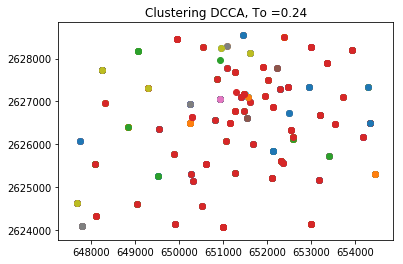

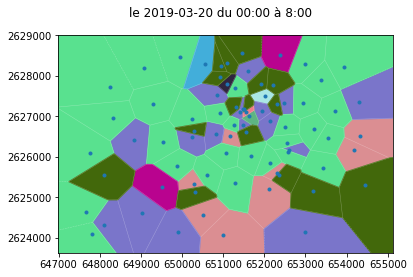

In [101]:
To=0.25
#P,l=apply_DCCA(F,r,To,CBBU)

T=DCCA.peak_tracking(CBBU,F1,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F1,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
affichage_vor(clusters,coord,color, "le 2019-03-20 du 00:00 à 8:00")

56


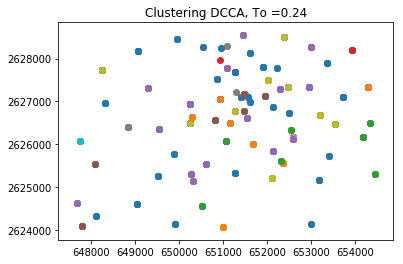

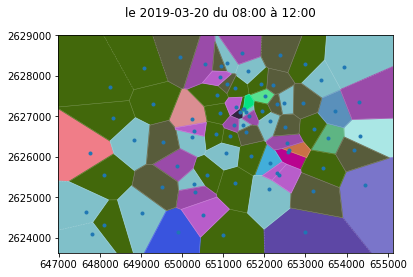

In [84]:
T=DCCA.peak_tracking(CBBU,F2,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F2,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
affichage_vor(clusters,coord,color, "le 2019-03-20 du 08:00 à 12:00")

38


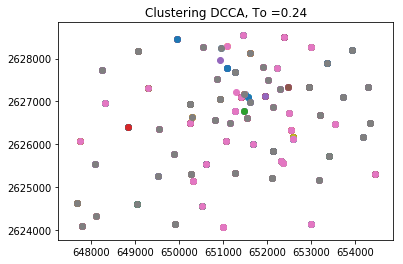

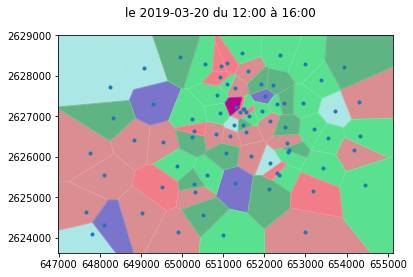

In [85]:
T=DCCA.peak_tracking(CBBU,F3,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F3,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
affichage_vor(clusters,coord,color, "le 2019-03-20 du 12:00 à 16:00")

39


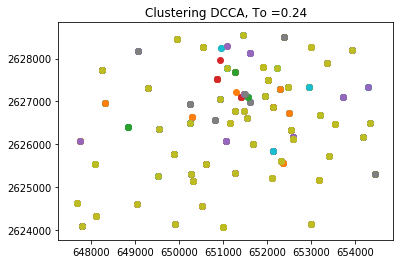

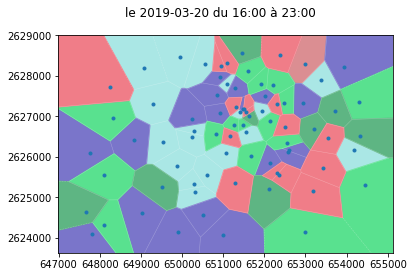

In [100]:
T=DCCA.peak_tracking(CBBU,F4,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F4,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
affichage_vor(clusters,coord,color, "le 2019-03-20 du 16:00 à 23:00")

## Weekend

In [87]:
F,Fup,r=generate_day_matrix("2019-03-31")
F_norm=DCCA.normalize_trafic(F)
for i in range(len(r)):
        r[i].setTrafic(F_norm[i])

In [88]:
F1=F_norm[:,0:8]
F2=F_norm[:,8:12]
F3=F_norm[:,12:16]
F4=F_norm[:,16:23]
print(np.shape(F1))

(772, 8)


48


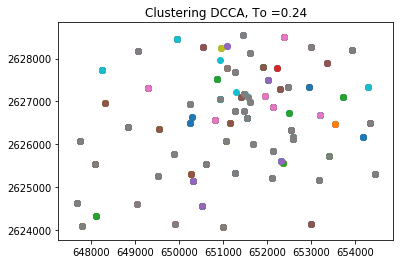

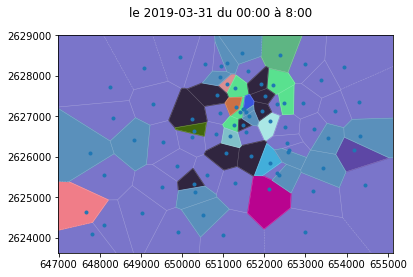

In [97]:
CBBU=8
To=0.25
#P,l=apply_DCCA(F,r,To,CBBU)

T=DCCA.peak_tracking(CBBU,F1,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F1,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
affichage_vor(clusters,coord,color, "le 2019-03-31 du 00:00 à 8:00")

43


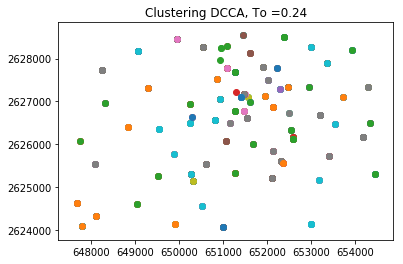

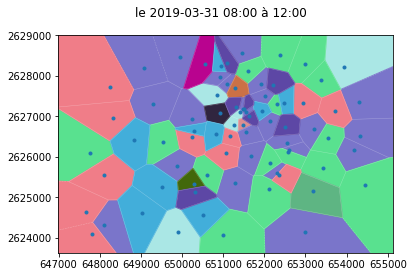

In [95]:
T=DCCA.peak_tracking(CBBU,F2,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F2,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
affichage_vor(clusters,coord,color, "le 2019-03-31 08:00 à 12:00")

53


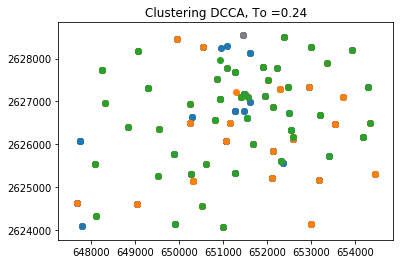

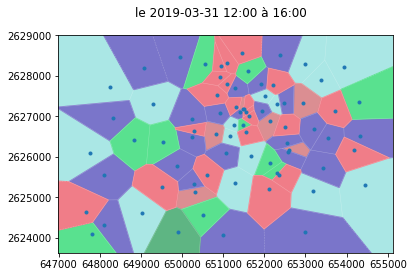

In [91]:
T=DCCA.peak_tracking(CBBU,F3,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F3,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
affichage_vor(clusters,coord,color, "le 2019-03-31 12:00 à 16:00")

41


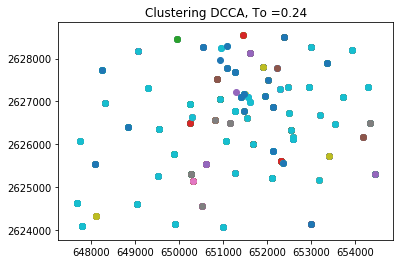

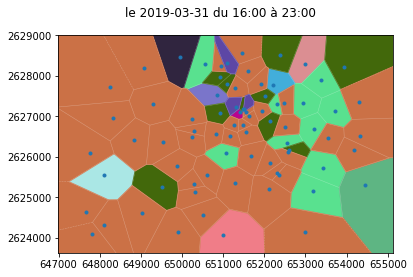

In [96]:
T=DCCA.peak_tracking(CBBU,F4,r)  
W=DCCA.matriceComplementarite(r,CBBU,To)
P,l=DCCA.iterative_DCCA (r,F4,CBBU,max_iter,To,iter_converge)
coord,clusters,k=display_cluster(P)
print(k)
affichage_vor(clusters,coord,color, "le 2019-03-31 du 16:00 à 23:00")